#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [190]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
path = '/content/drive/MyDrive/KT Aivle/Mini Project 6-1/'

### **(2) 라이브러리 설치 및 불러오기**

In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [288]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [289]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train.reshape(-1)) # reshape(-1) 추가함
    y_val = pd.Series(y_val.reshape(-1)) # reshape(-1) 추가함
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [290]:
a_data = pd.read_pickle('/content/drive/MyDrive/KT Aivle/Mini Project 6-1/data/a_data.pkl')
a_data

,Qty,y,CustomerCount,WTI_Price,Prev_Day_WTI_Price,One_Week_Ago_WTI_Price,7MA_WTI_Price,Year,Month,WeekDay,Season_Spring,Season_Summer,Season_Winter
Date,,,,,,,,,,,,,
2014-01-09,78.0,67.0,3723.0,91.360000,91.900000,95.1400,92.875714,2014,1,3,0,0,1
2014-01-10,96.0,93.0,4010.0,92.390000,91.360000,93.6600,92.694286,2014,1,4,0,0,1
2014-01-11,67.0,59.0,5053.0,92.076667,92.390000,93.4800,92.493810,2014,1,5,0,0,1
2014-01-12,93.0,63.0,4852.0,91.763333,92.076667,93.3000,92.274286,2014,1,6,0,0,1
2014-01-13,59.0,53.0,3913.0,91.450000,91.763333,93.1200,92.035714,2014,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-22,72.0,91.0,3834.0,53.610000,54.020000,53.1100,53.656429,2017,2,2,0,0,1
2017-02-23,98.0,105.0,3955.0,54.480000,53.610000,53.4100,53.809286,2017,2,3,0,0,1
2017-02-24,91.0,108.0,4549.0,53.990000,54.480000,53.4100,53.892143,2017,2,4,0,0,1


In [196]:
# with open('/content/drive/MyDrive/KT Aivle/Mini Project 6-1/data/df_beverage.pkl', 'rb') as f:
#     df_beverage = pickle.load(f)

In [197]:
# with open('/content/drive/MyDrive/KT Aivle/Mini Project 6-1/data/df_milk.pkl', 'rb') as f:
#     df_milk = pickle.load(f)

# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [291]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [292]:
x = a_data.drop('y', axis = 1)
y = a_data.loc[:, 'y']

In [293]:
# x
scaler_x = MinMaxScaler()
x = scaler_x.fit_transform(x)

In [297]:
x

array([[0.21854305, 0.20738588, 0.79708904, ..., 0.        , 0.        ,
        1.        ],
       [0.33774834, 0.25645409, 0.80968689, ..., 0.        , 0.        ,
        1.        ],
       [0.14569536, 0.43477518, 0.80585453, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.30463576, 0.3486066 , 0.34001957, ..., 0.        , 0.        ,
        1.        ],
       [0.39735099, 0.36057446, 0.34022342, ..., 0.        , 0.        ,
        1.        ],
       [0.41721854, 0.23371516, 0.34042727, ..., 0.        , 0.        ,
        1.        ]])

In [295]:
# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [296]:
y

array([[0.14569536],
       [0.31788079],
       [0.09271523],
       ...,
       [0.41721854],
       [0.21854305],
       [0.2781457 ]])

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [390]:
timesteps = 7
x2, y2 = temporalize(pd.DataFrame(x), pd.DataFrame(y), timesteps)

In [391]:
val_size = 7 * 12 # 독립 변수 12개
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)

In [392]:
n_features = x_train.shape[2]

* **모델링**

In [301]:
clear_session()

lstm_model = Sequential([LSTM(32, input_shape = (timesteps, n_features)),
                        Dense(1)])

lstm_model.compile(optimizer = Adam(learning_rate = 0.0001), loss='mse')

In [302]:
x_train.shape, y_train.shape

((1055, 7, 12), (1055, 1))

In [303]:
hist = lstm_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val)).history

Epoch 1/50
33/33 [==============================] - 2s 18ms/step - loss: 0.1237 - val_loss: 0.0465
Epoch 2/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0741 - val_loss: 0.0194
Epoch 3/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0506 - val_loss: 0.0132
Epoch 4/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0363 - val_loss: 0.0111
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0273 - val_loss: 0.0110
Epoch 6/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0221 - val_loss: 0.0113
Epoch 7/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0194 - val_loss: 0.0116
Epoch 8/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0180 - val_loss: 0.0116
Epoch 9/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0174 - val_loss: 0.0115
Epoch 10/50
33/33 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0118
Epoch 11/50
33/33 

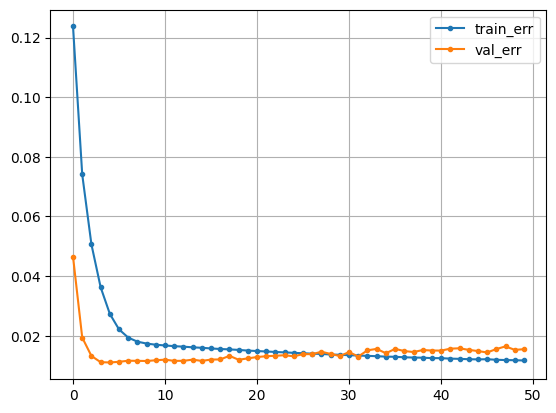

In [304]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [305]:
s_pred = lstm_model.predict(x_val)

3/3 [==============================] - 0s 4ms/step


In [306]:
# 평가
print('RMSE :', mean_squared_error(y_val, s_pred)**(1/2))
print('MAE :', mean_absolute_error(y_val, s_pred))
print('MAPE:', mean_absolute_percentage_error(y_val, s_pred))
print('R2  :', r2_score(y_val, s_pred))

RMSE : 0.12444628528027818
MAE : 0.10465573544843988
MAPE: 0.5297925086666473
R2  : -0.64435247035491


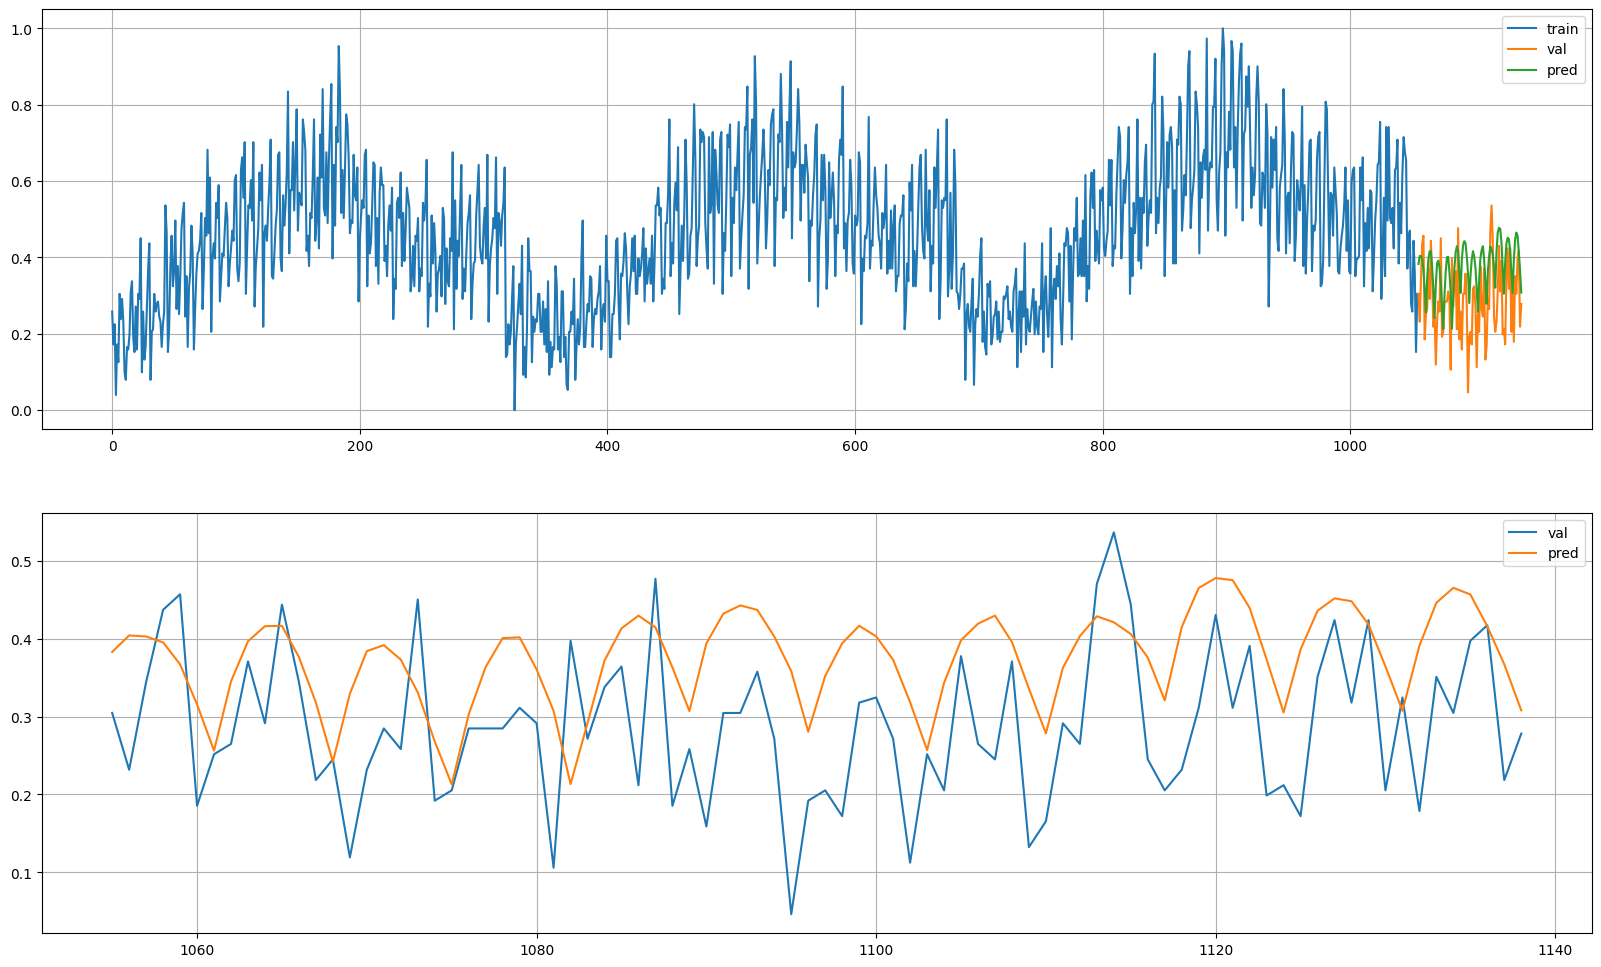

In [307]:
plot_model_result(y_train, y_val, s_pred)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

In [381]:
n_features = 12

In [382]:
clear_session()

cnn_model = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'), # (Kernel 32열, Kernel (5행), strides defalut는 1, padding은 그냥 same으로 줘야 같은 사이즈 나옴)
                    Flatten(), # 마지막 Dense 레이어와 연결하기 전에 꼭 해줘야 함
                    Dense(1)])

cnn_model.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

In [383]:
hist = cnn_model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val)).history

Epoch 1/30
33/33 [==============================] - 1s 8ms/step - loss: 0.0216 - val_loss: 0.0091
Epoch 2/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0077
Epoch 3/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 4/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 5/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0063
Epoch 6/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 7/30
33/33 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 8/30
33/33 [==============================] - 0s 5ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 9/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 0.0079
Epoch 10/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 11/30
33/33 [

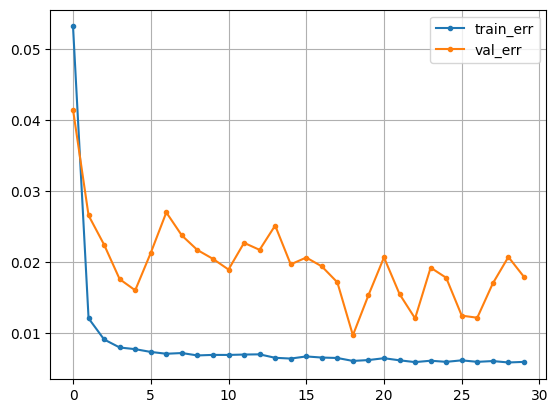

In [280]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [281]:
s_pred = cnn_model.predict(x_val)

3/3 [==============================] - 0s 3ms/step


In [282]:
# 평가
print('RMSE :', mean_squared_error(y_val, s_pred)**(1/2))
print('MAE :', mean_absolute_error(y_val, s_pred))
print('MAPE:', mean_absolute_percentage_error(y_val, s_pred))
print('R2  :', r2_score(y_val, s_pred))

RMSE : 0.13404850598100843
MAE : 0.11731046755530602
MAPE: 0.5360428745257336
R2  : -0.9078973120502796


In [283]:
s_pred.shape

(84, 1)

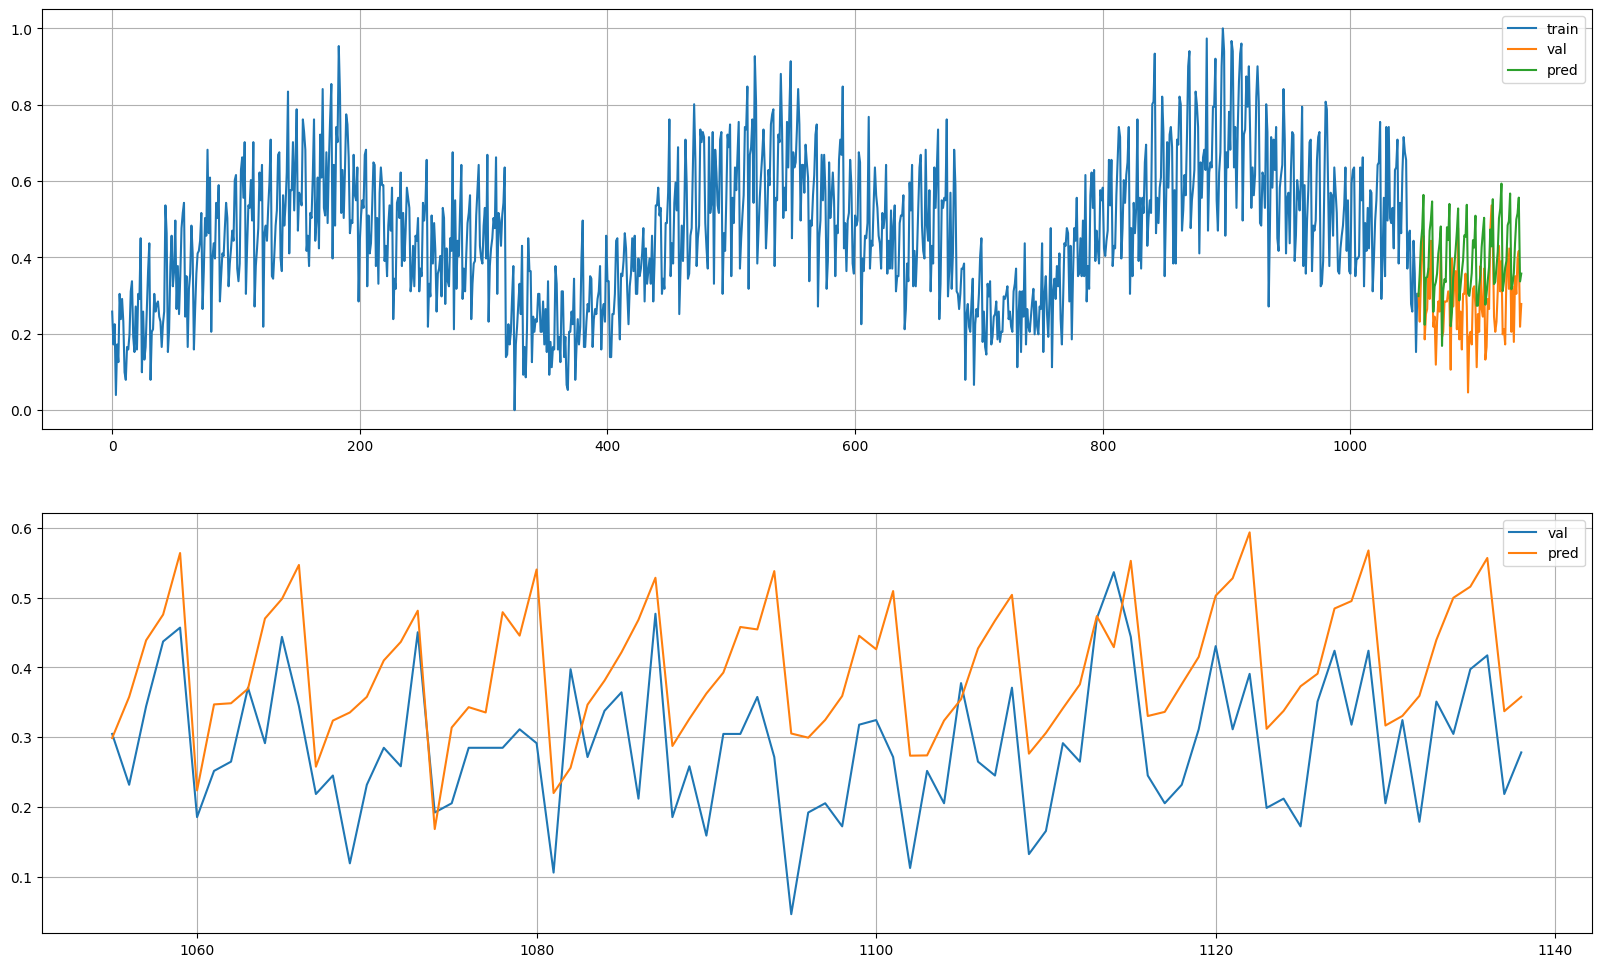

In [284]:
plot_model_result(y_train, y_val, s_pred)

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [417]:
def preprocessing_for_predict(sales_test, orders_test, oil_price_test, products, stores, product_ID = 42):

    # Store 44 일별 매장별 고객 방문 수
    my_orders = orders_test.loc[(orders_test['Store_ID'] == 44)].reset_index(drop=True)
    # Store 44 판매 정보
    my_sales = sales_test.loc[sales_test['Store_ID'] == 44].reset_index(drop=True)
    # Store 44 Agricultural products 판매 정보
    a_sales = sales_test.loc[(sales_test['Store_ID'] == 44) & (sales_test['Product_ID'] == product_ID)].reset_index(drop=True)
    # Store 44 매장 기본 정보
    my_stores = stores.loc[(stores['Store_ID'] == 44)].reset_index(drop=True)

    # 모델링에 사용할 데이터셋 생성
    a_data = a_sales.copy()

    a_data.drop(columns = ['Store_ID', 'Product_ID'], inplace=True)

    # 타겟변수: # Lead Time이 2이므로 이틀 뒤 판매량 예측이 목표 → 날짜를 기준으로 이틀 뒤 판매량(y) 추가
    a_data['y'] = a_data['Qty'].shift(-2)

    a_data = pd.merge(a_data, my_orders, on='Date', how='left')
    a_data.drop(columns = ['Store_ID'], inplace=True)
    # 선형보간법으로 결측치 채움
    a_data['CustomerCount'] = a_data['CustomerCount'].interpolate(method='linear')

    # 데이터셋에 유가 데이터 추가 (날짜 기준으로)
    a_data = pd.merge(a_data, oil_price_test, on='Date', how='left')
    # 시계열 데이터이므로 선형보간법으로 결측치 채움
    a_data['WTI_Price'] = a_data['WTI_Price'].interpolate(method='linear')

    # 하루 전 유가, 7일 전 유가, 7일 간 이동평균 유가 계산해 열 추가
    # 하루 전
    a_data['Prev_Day_WTI_Price'] = a_data['WTI_Price'].shift(1)
    # 일주일 전
    a_data['One_Week_Ago_WTI_Price'] = a_data['WTI_Price'].shift(7)
    # 7일 간 이동평균
    a_data['7MA_WTI_Price'] = a_data['WTI_Price'].rolling(window = 7).mean()
    a_data.head(10)

    # 연도와 월, 요일, 계절을 추출하여 새로운 열로 추가
    # 연도
    a_data['Year'] = a_data['Date'].dt.year
    # 월
    a_data['Month'] = a_data['Date'].dt.month
    # 요일
    a_data['WeekDay'] = a_data['Date'].dt.weekday # 월(0)~일(6)
    # 계절
    # def get_season(month):
    #     if month in [3, 4, 5]:
    #         return 'Spring'
    #     elif month in [6, 7, 8]:
    #         return 'Summer'
    #     elif month in [9, 10, 11]:
    #         return 'Fall'
    #     elif month in [12, 1, 2]:
    #         return 'Winter'
    # a_data['Season'] = a_data['Date'].dt.month.apply(get_season)

    # # 계절 변수 가변수화
    # a_data = pd.get_dummies(a_data, columns = ['Season'], drop_first = True, dtype = int)

    # test_data에는 Spring 데이터밖에 없음
    a_data['Season_Spring'] = 1
    a_data['Season_Summer'] = 0
    a_data['Season_Winter'] = 0

    # 날짜를 index로
    a_data.set_index('Date', inplace = True)

    # 앞뒤 결측치 제거
    a_data.dropna(how='any', inplace = True)

    x_test = a_data.drop('y', axis = 1)
    y_test = a_data.loc[:, 'y']

    # y 최대최소값 출력
    y_max = max(y_test)
    y_min = min(y_test)

    # x 스케일링
    scaler_x = MinMaxScaler()
    x_test = scaler_x.fit_transform(x_test)
    # y 스케일링(최적화를 위해)
    scaler_y = MinMaxScaler()
    y_test = scaler_y.fit_transform(y_test.values.reshape(-1, 1))

    # 2차원 → 3차원 변환 (for LSTM, CNN)
    def temporalize(x, y, timesteps):
        output_X = []
        output_y = []
        for i in range(len(x) - timesteps + 1):
            output_X.append(x.iloc[i:i+timesteps])
            output_y.append(y.iloc[i+timesteps-1])
        return np.array(output_X), np.array(output_y)

    # LSTM과 CNN 위한 temporalize
    timesteps = 7
    x_test, y_test = temporalize(pd.DataFrame(x_test), pd.DataFrame(y_test), timesteps) # pd.DataFrame 추가

    return x_test, y_test, y_max, y_min

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [387]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [418]:
x_test, y_test, y_max, y_min = preprocessing_for_predict(sales_test, orders_test, oil_price_test, products, stores, product_ID = 42)

* 예측해보기

LSTM

In [313]:
s_pred = lstm_model.predict(x_test)

1/1 [==============================] - 0s 20ms/step


In [314]:
# 평가
print('RMSE :', mean_squared_error(y_test, s_pred)**(1/2))
print('MAE :', mean_absolute_error(y_test, s_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, s_pred))
print('R2  :', r2_score(y_test, s_pred))

RMSE : 0.27480379351899675
MAE : 0.23774246746166183
MAPE: 121194212753410.28
R2  : -0.03249402449990968


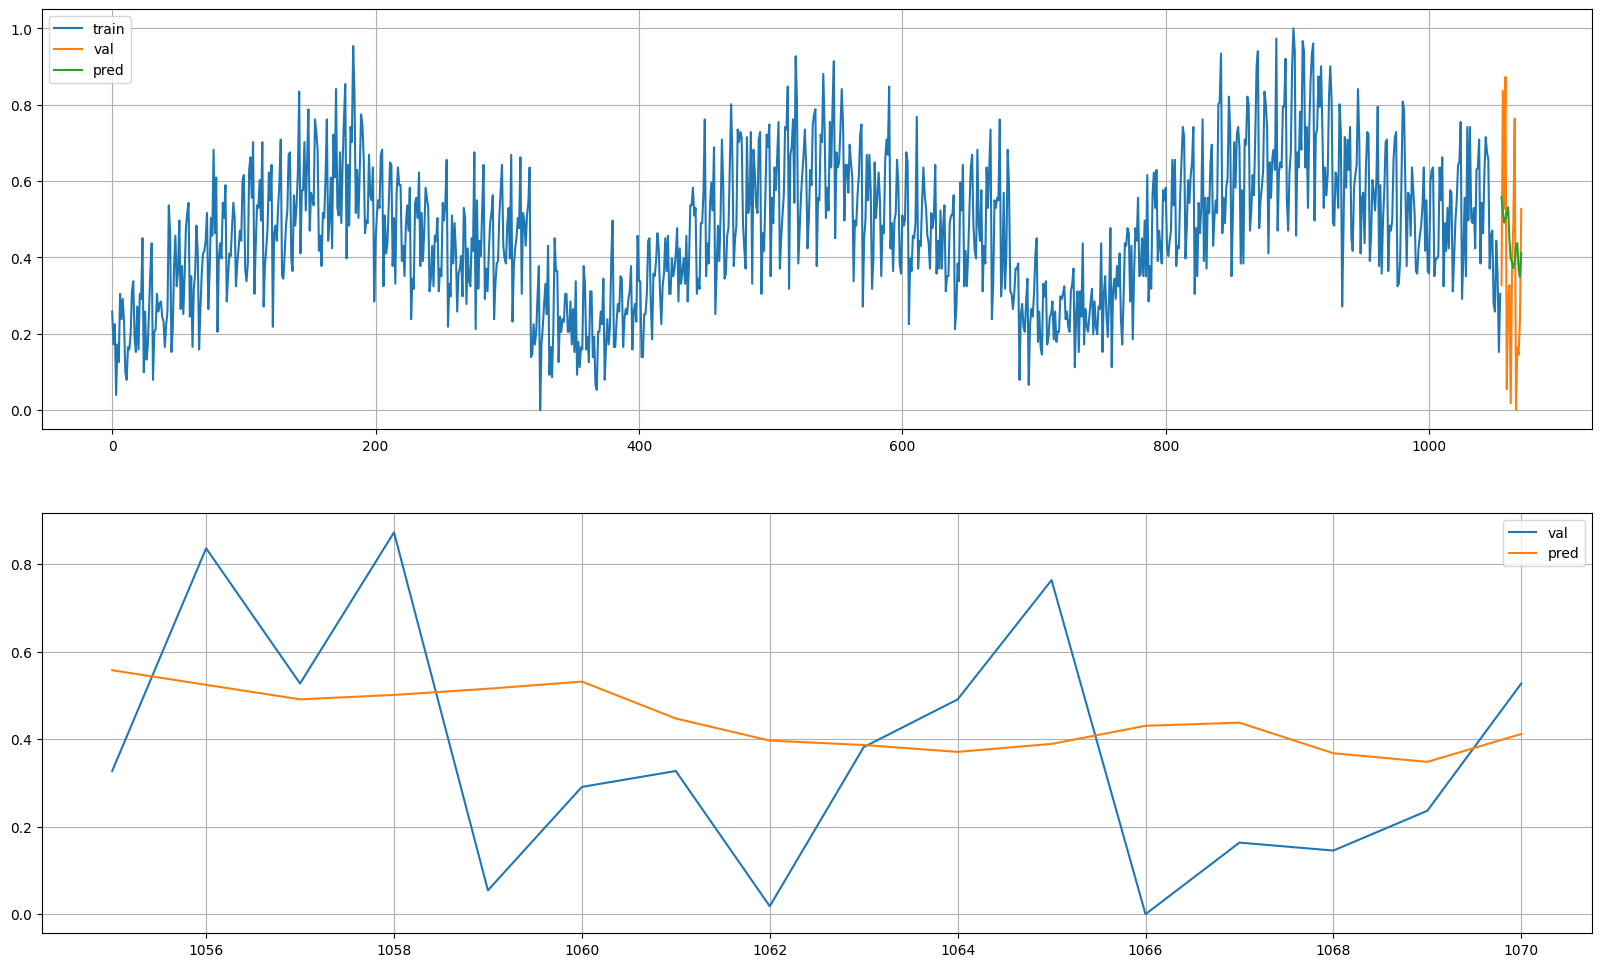

In [315]:
plot_model_result(y_train, y_test, s_pred)

CNN

In [320]:
x_test.shape

(16, 7, 9)

In [396]:
s_pred2 = cnn_model.predict(x_test)

1/1 [==============================] - 0s 115ms/step


In [401]:
# 평가
print('RMSE :', mean_squared_error(y_test, s_pred2)**(1/2))
print('MAE :', mean_absolute_error(y_test, s_pred2))
print('MAPE:', mean_absolute_percentage_error(y_test, s_pred2))
print('R2  :', r2_score(y_test, s_pred2))

RMSE : 0.18829070480501073
MAE : 0.14708733236925164
MAPE: 43840476020737.48
R2  : 0.5152700416460914


In [416]:
s_pred2

array([[0.32785493],
       [0.4378847 ],
       [0.65283525],
       [0.59179306],
       [0.22044982],
       [0.37250027],
       [0.15754704],
       [0.3246302 ],
       [0.3505281 ],
       [0.47589606],
       [0.44307488],
       [0.15575266],
       [0.27456465],
       [0.13460019],
       [0.32012016],
       [0.43125933]], dtype=float32)

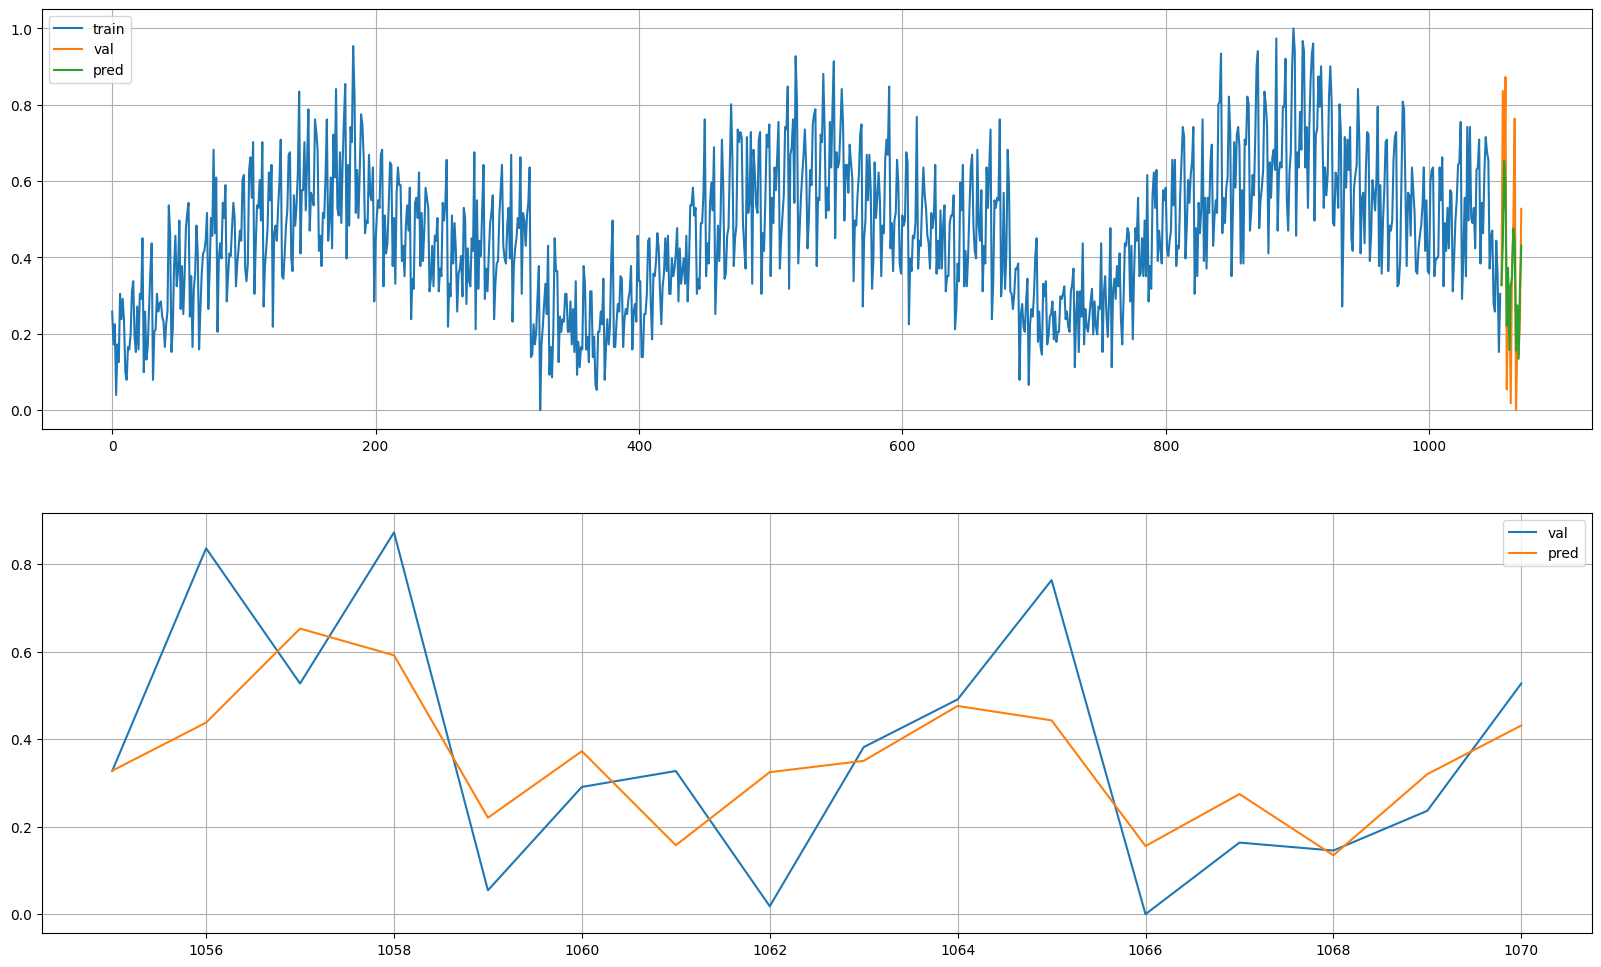

In [404]:
plot_model_result(y_train, y_test, s_pred2)

# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_scaled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [228]:
def inv_simulator(y, pred, safe_stock, price) : # 안전재고, 예측하려는 제품의 가격

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [419]:
y_r = y_test * (y_max - y_min) + y_min
pred_r = s_pred2 * (y_max - y_min) + y_min

In [420]:
pred_r

array([[108.03202 ],
       [114.08366 ],
       [125.90594 ],
       [122.548615],
       [102.12474 ],
       [110.48752 ],
       [ 98.665085],
       [107.85466 ],
       [109.279045],
       [116.174286],
       [114.36912 ],
       [ 98.5664  ],
       [105.10106 ],
       [ 97.40301 ],
       [107.60661 ],
       [113.71926 ]], dtype=float32)

In [421]:
y_r.shape, pred_r.shape

((16, 1), (16, 1))

In [430]:
result = inv_simulator(y_r, pred_r, 35000, 8)

일평균 재고량     : 35057.143
일평균 재고 금액  : 280457.144
일평균 재고회전율 : 0.003
기회손실 수량     : 0.0


In [431]:
result

,y,pred,base_stock,close_stock,order,receive,lost
0,108.0,108.0,35108,35000,126,108,0.0
1,136.0,114.0,35136,35000,123,136,0.0
2,119.0,126.0,35126,35007,95,126,0.0
3,138.0,123.0,35130,34992,118,123,0.0
4,93.0,102.0,35087,34994,105,95,0.0
5,106.0,110.0,35112,35006,102,118,0.0
6,108.0,99.0,35111,35003,106,105,0.0
7,91.0,108.0,35105,35014,102,102,0.0
8,111.0,109.0,35120,35009,105,106,0.0
9,117.0,116.0,35111,34994,105,102,0.0
